In [54]:
import nltk
from nltk.corpus import conll2000
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

import kg.ner.utils as utils
from kg.ner.unsupervised import NounPhraseDetection, TFIDFScore, TextRankScore

In [55]:
data_directory = '/Users/tmorrill002/Documents/datasets/conll/transformed'

In [56]:
df_dict = utils.load_train_data(data_directory)

## What fraction of NER tags are Noun Phrases?

In [57]:
train_df = df_dict['train.csv']

In [58]:
def nouns_over_NER(df, noun_col = 'Chunk_Tag', ner_col = 'NER_Tag_Normalized'):
    ner_df = df[df[ner_col] != 'O']
    noun_phrase_token_count = len(ner_df[(ner_df[noun_col] == 'I-NP') | (ner_df[noun_col] == 'B-NP')])
    print(f'Count of noun phrase tokens among NER tokens: {noun_phrase_token_count}')
    print(f'Count of NER tokens: {len(ner_df)}')
    print(f'Percent of NER tokens that are part of noun phrases: {round(noun_phrase_token_count / len(ner_df),4) * 100}%')

In [59]:
nouns_over_NER(train_df)

Count of noun phrase tokens among NER tokens: 33054
Count of NER tokens: 34043
Percent of NER tokens that are part of noun phrases: 97.09%


## What fraction of Noun Phrase tokens are NER tagged?

In [60]:
def NER_over_nouns(df, noun_col = 'Chunk_Tag', ner_col = 'NER_Tag_Normalized'):
    noun_phrase_df = df[(df[noun_col] == 'I-NP') | (df[noun_col] == 'B-NP')]
    ner_tag_token_count = len(noun_phrase_df[noun_phrase_df[ner_col] != 'O'])
    print(f'Count of NER tokens among noun phrase tokens: {ner_tag_token_count}')
    print(f'Count of noun phrase tokens: {len(noun_phrase_df)}')
    print(f'Percent of noun phrase tokens that are part of NER tags: {round(ner_tag_token_count / len(noun_phrase_df), 4) * 100}%')

In [61]:
NER_over_nouns(train_df)

Count of NER tokens among noun phrase tokens: 33054
Count of noun phrase tokens: 124032
Percent of noun phrase tokens that are part of NER tags: 26.650000000000002%


### Conclusions:
1. NER Tags are almost exclusively noun phrases (97%) -> noun phrase candidates will yield high recall
2. Noun phrases encompass a lot more than NER tags -> noun phrase candidates will yield low precision and other techniques should be used to reduce the number of false positives

### Evaluate Unsupervised Noun Phrase Detection Against CoNLL-2000 and CoNLL-2003

In [62]:
conll_2000_test_sentences = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [63]:
chunk_parser = NounPhraseDetection()

In [64]:
print(chunk_parser.evaluate(conll_2000_test_sentences))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


In [65]:
def consolidate(x):
    return (x['Token'], x['POS_Tag'], x['Chunk_Tag'])

In [66]:
train_df['Tags'] = train_df.apply(consolidate, axis=1) #passes a Series object, row-wise

In [67]:
# ground truth labeled data containing (token, pos, chunk), used for evaluation
train_conll_2003 = train_df.groupby(['Article_ID', 'Sentence_ID'], )['Tags'].apply(list).values.tolist()

In [68]:
# pos tagged sentences only containing (token, pos), used to make predictions
train_conll_2003_pos_tags = []
for sentence in train_conll_2003:
    temp_sentence = []
    for token, pos, chunk in sentence:
        temp_sentence.append((token, pos))
    train_conll_2003_pos_tags.append(temp_sentence)

In [69]:
# examples must be in "tree" format to use evaluation code
trees = []
for example in train_conll_2003:
    trees.append(nltk.chunk.conlltags2tree(example))

In [70]:
# getting harmed here because B-NP tags aren't marked appropriately in CoNLL-2003
print(chunk_parser.evaluate(trees))

ChunkParse score:
    IOB Accuracy:  67.4%%
    Precision:     80.5%%
    Recall:        43.7%%
    F-Measure:     56.7%%


In [71]:
prediction_trees = []
for example in train_conll_2003_pos_tags:
    prediction_trees.append(chunk_parser.parse(example))

In [72]:
predictions = []
for sentence in prediction_trees:
    predictions.append(nltk.chunk.tree2conlltags(sentence))

In [73]:
flattened = [prediction for sentence in predictions for prediction in sentence ]

In [74]:
train_df['Prediction'] = flattened

In [75]:
train_df['Prediction'] = train_df['Prediction'].apply(lambda x: x[2])

In [76]:
train_df['Noun_Phrase'] = train_df['Prediction'] != 'O'

In [77]:
nouns_over_NER(train_df, 'Prediction', 'NER_Tag_Normalized')

Count of noun phrase tokens among NER tokens: 33030
Count of NER tokens: 34043
Percent of NER tokens that are part of noun phrases: 97.02%


In [78]:
NER_over_nouns(train_df, 'Prediction', 'NER_Tag_Normalized')

Count of NER tokens among noun phrase tokens: 33030
Count of noun phrase tokens: 124428
Percent of noun phrase tokens that are part of NER tags: 26.55%


In [79]:
train_df['NP_Chunk_Tag'] = (train_df['Chunk_Tag'] == 'I-NP') | (train_df['Chunk_Tag'] == 'B-NP')

In [80]:
# agreement between existing ConLL-2003 noun phrase tags and the predicted tags
(train_df['Noun_Phrase'] == train_df['NP_Chunk_Tag']).sum() / len(train_df)

0.9570476522559068

## Evaluate TF-IDF Rankings

In [81]:
entity_extractor = TFIDFScore(chunk_parser)

In [82]:
train_df['NER_Tag_Flag'] = train_df['NER_Tag'] != 'O'

In [83]:
# gather up articles
articles = train_df.groupby(['Article_ID'], )['Token'].apply(lambda x: ' '.join([str(y) for y in list(x)])).values.tolist()

In [84]:
# fit TFIDF model
entity_extractor.fit(articles)

In [85]:
# get candidate phrases
candidates = []
for article in articles:
    # manually tokenize because nltk tokenizer is converting 'C$' -> ['C', '$'] and throwing off comparison
    sentences = utils.tokenize_text(article)
    article = [sentence.split() for sentence in sentences]
    article = utils.tag_pos(article)
    for candidate in entity_extractor.candidates(article, preprocess = False):
        candidates.append(candidate)

In [86]:
scores = entity_extractor.score_phrases(candidates)

/Users/tmorrill002/Documents/knowledge-graphs/kg/ner/unsupervised.py:192: RuntimeWarning: invalid value encountered in true_divide
  scores = sums / token_counts


In [87]:
def prepare_scored_phrases(scored_candidates):
    df = pd.DataFrame(scored_candidates, columns=['Predicted_Phrase', 'Noun_Phrase_Flag', 'Score'])
    df['Phrase_ID'] = df.index
    df['Predicted_Phrase'] = df['Predicted_Phrase'].apply(lambda x: x.split())
    df = df.explode('Predicted_Phrase')
    # punctuation isn't getting assigned a score, fill with zero for now
    df['Score'] = df['Score'].fillna(0.0)
    # TODO: Investigate why this is happening
    df['Predicted_Phrase'] = df['Predicted_Phrase'].replace('``', '"')
    return df

In [88]:
prediction_df = prepare_scored_phrases(scores)

In [89]:
def merge_dfs(train_df, prediction_df):
    
    assert len(train_df) == len(prediction_df)
    eval_df = pd.concat((train_df, prediction_df.reset_index(drop=True)), axis=1)

    # TODO: why are some CoNLL-2003 tokens NaN?
    eval_df = eval_df.dropna(subset=['Token'])
    assert (eval_df['Token'] == eval_df['Predicted_Phrase']).sum() == len(eval_df) 
    
    eval_df['Predicted_Entity_Flag'] = eval_df['Noun_Phrase_Flag']
    
    return eval_df

In [90]:
tfidf_eval_df = merge_dfs(train_df, prediction_df)

In [122]:
def optimize_threshold(eval_df, scoring_method='TFIDF', optimization_steps=32):
    # optimize threshold to maximize macro f1
    start = eval_df['Score'].describe()['25%']
    stop = eval_df['Score'].describe()['75%']
    step = (stop - start) / optimization_steps
    
    predictions = []
    for thresh in np.arange(start, stop, step=step):
        predictions.append((thresh, (eval_df['Noun_Phrase_Flag'] & (eval_df['Score'] >= thresh)).values))

    scores = []
    for prediction in predictions:
        report = classification_report(eval_df['NER_Tag_Flag'], prediction[1], output_dict=True)
        scores.append((prediction[0], report['True']['f1-score'], report['True']['precision'], report['True']['recall']))

    optimized_threshold = max(scores, key=lambda x: x[1])[0]
    
    print(f'Optimize {scoring_method} threshold ({optimized_threshold}) to maximize positive class (Entity = True) F1 score.')
    print(f'Range searched - start: {start}, stop: {stop}, step: {step}')
    print(classification_report(eval_df['NER_Tag_Flag'], (eval_df['Noun_Phrase_Flag'] & (eval_df['Score'] >= optimized_threshold))))
    
    return optimized_threshold, scores

In [123]:
def evaluate(eval_df, scoring_method='TFIDF', optimization_steps=32):
    # baseline of just using noun phrases to identify entities (high recall, low precision)
    print('Baseline using noun phrases to identify entities:')
    print(classification_report(eval_df['NER_Tag_Flag'], eval_df['Predicted_Entity_Flag']))
    print()
    
    # use score and a threshold
    median_threshold = eval_df['Score'].describe()['50%']
    eval_df[f'Predicted_Entity_Flag_{scoring_method}_Median'] = (eval_df['Noun_Phrase_Flag'] & (eval_df['Score'] > median_threshold))
    print(f'Use the median {scoring_method} score ({round(median_threshold, 4)}) as a threshold to identify entities.')
    print(classification_report(eval_df['NER_Tag_Flag'], eval_df[f'Predicted_Entity_Flag_{scoring_method}_Median']))
    print()
    
    return optimize_threshold(eval_df, scoring_method, optimization_steps)

In [93]:
evaluate(tfidf_eval_df)

Baseline using noun phrases to identify entities:
              precision    recall  f1-score   support

       False       0.99      0.51      0.68    169575
        True       0.29      0.98      0.44     34043

    accuracy                           0.59    203618
   macro avg       0.64      0.74      0.56    203618
weighted avg       0.87      0.59      0.64    203618


Use the median TFIDF score (3.8135) as a threshold to identify entities.
              precision    recall  f1-score   support

       False       0.95      0.69      0.80    169575
        True       0.34      0.81      0.48     34043

    accuracy                           0.71    203618
   macro avg       0.64      0.75      0.64    203618
weighted avg       0.85      0.71      0.74    203618


Optimize TFIDF threshold (4.497740067462728) to maximize positive class (Entity = True) F1 score.
Range searched - start: 2.694243793971549, stop: 4.913931515191463, step: 0.0693652412881223
              precision    rec

4.497740067462728

## Evaluate TextRank Rankings

In [94]:
chunk_parser = NounPhraseDetection()
for article in articles[:1]:
    scorer = TextRankScore(article, preprocess=True, parser=chunk_parser)
    scorer.fit()
    candidates = scorer.candidates(article, )
    scores = scorer.score_phrases(candidates)

In [95]:
# get candidate phrases
scored_candidates = []
for idx, article in enumerate(articles):
    # fit TextRank for article
    scorer = TextRankScore(article, preprocess=True, parser=chunk_parser)
    scorer.fit()
    
    # manually tokenize because nltk tokenizer is converting 'C$' -> ['C', '$'] and throwing off comparison
    sentences = utils.tokenize_text(article)
    article = [sentence.split() for sentence in sentences]
    article = utils.tag_pos(article)
    candidates = scorer.candidates(article, preprocess = False)
        
    # score candidates
    for candidate in scorer.score_phrases(candidates):
        scored_candidates.append(candidate)
    if idx % 100 == 0:
        print(idx)

0
100
200
300
400
500
600
700
800
900


In [96]:
len(scored_candidates)

101152

In [97]:
text_rank_df = prepare_scored_phrases(scored_candidates)

In [98]:
text_rank_df

,Predicted_Phrase,Noun_Phrase_Flag,Score,Phrase_ID
0,EU,True,0.052326,0
1,rejects,False,0.000000,1
2,German,True,0.488372,2
2,call,True,0.488372,2
3,to,False,0.000000,3
...,...,...,...,...
101151,three,True,1.000000,101151
101151,Swansea,True,1.000000,101151
101151,1,True,1.000000,101151
101151,Lincoln,True,1.000000,101151


In [99]:
text_rank_eval_df = merge_dfs(train_df, text_rank_df)

<AxesSubplot:ylabel='Density'>

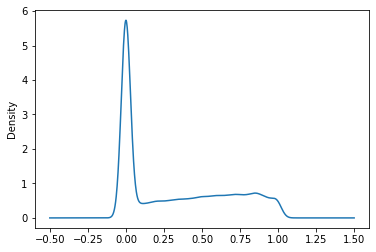

In [100]:
text_rank_eval_df['Score'].plot(kind='density')

In [124]:
results = evaluate(text_rank_eval_df, scoring_method='TextRank', optimization_steps=100)

Baseline using noun phrases to identify entities:
              precision    recall  f1-score   support

       False       0.99      0.51      0.68    169575
        True       0.29      0.98      0.44     34043

    accuracy                           0.59    203618
   macro avg       0.64      0.74      0.56    203618
weighted avg       0.87      0.59      0.64    203618


Use the median TextRank score (0.2) as a threshold to identify entities.
              precision    recall  f1-score   support

       False       0.94      0.56      0.70    169575
        True       0.27      0.81      0.41     34043

    accuracy                           0.60    203618
   macro avg       0.60      0.69      0.56    203618
weighted avg       0.83      0.60      0.65    203618


Optimize TextRank threshold (0.02564102564102564) to maximize positive class (Entity = True) F1 score.
Range searched - start: 0.0, stop: 0.641025641025641, step: 0.00641025641025641
              precision    recall  f1-

### Why is precision going down as we increase the threshold? Are higher thresholds associated with more false positives?

<AxesSubplot:xlabel='Threshold'>

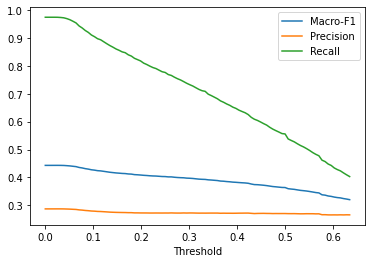

In [138]:
results_df = pd.DataFrame(results[1], columns=['Threshold', 'Macro-F1', 'Precision', 'Recall'])

results_df.index = results_df['Threshold']

results_df.drop(columns=['Threshold']).plot()

In [139]:
above_thresh_df = text_rank_eval_df[(text_rank_eval_df['Score'] >= text_rank_eval_df['Score'].describe()['50%']) & text_rank_eval_df['Predicted_Entity_Flag']]

In [140]:
below_thresh_df = text_rank_eval_df[(text_rank_eval_df['Score'] < text_rank_eval_df['Score'].describe()['50%']) & text_rank_eval_df['Predicted_Entity_Flag']]

In [141]:
above_thresh_df['NER_Tag_Flag'].sum() / len(above_thresh_df)

0.27209758009209367

In [142]:
below_thresh_df['NER_Tag_Flag'].sum() / len(below_thresh_df)

0.39342362569711015

In [143]:
above_thresh_df.sort_values('Score').iloc[:15]

,Article_ID,Sentence_ID,Token_ID,Token,POS_Tag,Chunk_Tag,NER_Tag,NER_Tag_ID,NER_Tag_Normalized,Tags,...,Noun_Phrase,NP_Chunk_Tag,NER_Tag_Flag,Predicted_Phrase,Noun_Phrase_Flag,Score,Phrase_ID,Predicted_Entity_Flag,Predicted_Entity_Flag_TFIDF_Median,Predicted_Entity_Flag_TextRank_Median
131561,603,3,2,rise,NN,I-NP,O,NaN,O,"(rise, NN, I-NP)",...,True,True,False,rise,True,0.2,64664,True,False,False
193164,893,1,0,DUBAI,NNP,I-NP,I-LOC,22570.0,LOC,"(DUBAI, NNP, I-NP)",...,True,True,True,DUBAI,True,0.2,95657,True,False,False
193165,893,1,1,1996-08-29,CD,I-NP,O,NaN,O,"(1996-08-29, CD, I-NP)",...,True,True,False,1996-08-29,True,0.2,95657,True,False,False
193166,893,2,0,Washington,NNP,I-NP,I-LOC,22571.0,LOC,"(Washington, NNP, I-NP)",...,True,True,True,Washington,True,0.2,95657,True,False,False
20719,101,16,4,time,NN,I-NP,O,NaN,O,"(time, NN, I-NP)",...,True,True,False,time,True,0.2,11041,True,False,False
95789,450,28,7,nationalistic,JJ,I-NP,O,NaN,O,"(nationalistic, JJ, I-NP)",...,True,True,False,nationalistic,True,0.2,46860,True,False,False
95790,450,28,8,political,JJ,I-NP,O,NaN,O,"(political, JJ, I-NP)",...,True,True,False,political,True,0.2,46860,True,False,False
95791,450,28,9,leaders,NNS,I-NP,O,NaN,O,"(leaders, NNS, I-NP)",...,True,True,False,leaders,True,0.2,46860,True,False,False
20718,101,16,3,high,JJ,I-NP,O,NaN,O,"(high, JJ, I-NP)",...,True,True,False,high,True,0.2,11041,True,False,False
51770,249,7,5,229-1,CD,I-NP,O,NaN,O,"(229-1, CD, I-NP)",...,True,True,False,229-1,True,0.2,27093,True,False,False
